In [12]:
# =================================================
# demo2: key_factors_identification
# =================================================

import shap
import cmaps
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skexplain import ExplainToolkit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 18

Performing grid search...
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best parameters for XGBoost model: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 5, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
Model Evaluation Results:
Training set metrics:
R²: 0.8768
RMSE: 3.0062
MAE: 2.4049
MAPE: 3.0589%
----------------------------------------
Test set metrics:
R²: 0.5511
RMSE: 5.6619
MAE: 4.9697
MAPE: 6.4980%
----------------------------------------


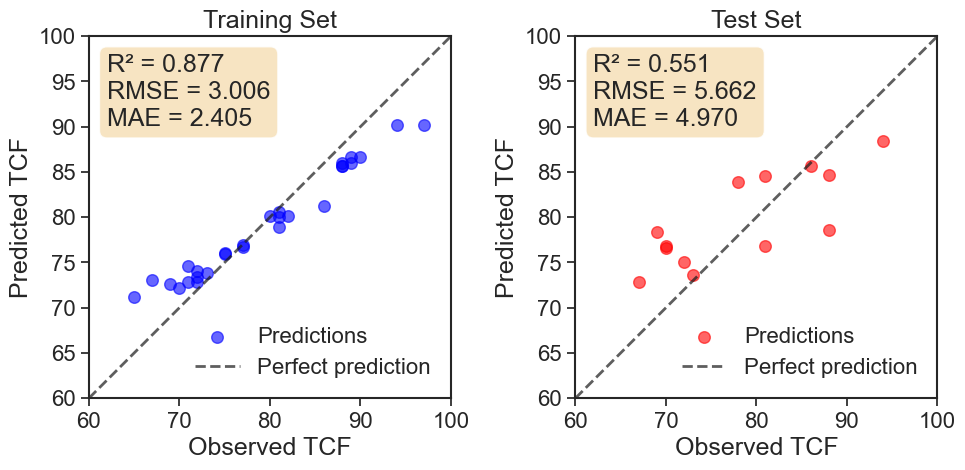

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    
    Parameters:
    y_true: array-like of true values
    y_pred: array-like of predicted values
    
    Returns:
    mape: float, MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def root_mean_squared_error(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE)
    
    Parameters:
    y_true: array-like of true values
    y_pred: array-like of predicted values
    
    Returns:
    rmse: float, RMSE value
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X, y, name='Test'):
    """
    Evaluate model performance and create visualization
    
    Parameters:
    model: trained model object
    X: feature matrix
    y: target values
    name: string, name of the dataset (e.g., 'Training', 'Test')
    """
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate evaluation metrics
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred) * 100
    
    # Print evaluation metrics
    print(f'{name} set metrics:')
    print(f'R²: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.4f}%')
    print('-' * 40)
    
    return r2, rmse, mae, mape, y_pred

def plot_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test, metrics_train, metrics_test):
    """
    Create subplots for training and test set predictions
    
    Parameters:
    y_true_train: true values for training set
    y_pred_train: predicted values for training set
    y_true_test: true values for test set
    y_pred_test: predicted values for test set
    metrics_train: tuple of metrics for training set (r2, rmse, mae, mape)
    metrics_test: tuple of metrics for test set (r2, rmse, mae, mape)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Training set plot
    ax1.scatter(y_true_train, y_pred_train, s=70, alpha=0.6, color='blue', label='Predictions')
    ax1.plot([60, 100], [60, 100], 'k--', lw=2, alpha=0.7, label='Perfect prediction')
    ax1.set_xlim([60, 100])
    ax1.set_ylim([60, 100])
    ax1.set_title('Training Set', fontsize=18,)
    ax1.set_xlabel('Observed TCF', fontsize=18)
    ax1.set_ylabel('Predicted TCF', fontsize=18)
    ax1.tick_params(axis='both', labelsize=16)
    ax1.legend(frameon=False, fontsize=16)
    ax1.grid(False)
    ax1.set_aspect('equal')
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    
    # Add metrics text to training plot
    r2_train, rmse_train, mae_train, mape_train = metrics_train
    ax1.text(0.05, 0.95, f'R² = {r2_train:.3f}\nRMSE = {rmse_train:.3f}\nMAE = {mae_train:.3f}', transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Test set plot
    ax2.scatter(y_true_test, y_pred_test, s=70, alpha=0.6, color='red', label='Predictions')
    ax2.plot([60, 100], [60, 100], 'k--', lw=2, alpha=0.7, label='Perfect prediction')
    ax2.set_xlim([60, 100])
    ax2.set_ylim([60, 100])
    ax2.set_title('Test Set', fontsize=18,)
    ax2.set_xlabel('Observed TCF', fontsize=18)
    ax2.set_ylabel('Predicted TCF', fontsize=18)
    ax2.tick_params(axis='both', labelsize=16)
    ax2.legend(frameon=False, fontsize=16)
    ax2.grid(False)
    ax2.set_aspect('equal')
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    
    # Add metrics text to test plot
    r2_test, rmse_test, mae_test, mape_test = metrics_test
    ax2.text(0.05, 0.95, f'R² = {r2_test:.3f}\nRMSE = {rmse_test:.3f}\nMAE = {mae_test:.3f}', transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    # plt.savefig('1.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load data
IML_data = pd.read_csv('IML_data.csv')

# Prepare features and target for global-scale analysis
X = IML_data.filter(regex='Global_') 
y = IML_data['Global']               

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=1577
)

# Initialize XGBoost regressor
xgb = XGBRegressor(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    min_child_weight=1.0,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=1577,  
)

# Define parameter grid for grid search
xgb_params = {
    'n_estimators': range(5, 15),
    'max_depth': [5, 10, 15],
    'learning_rate': [0.3, 0.4, 0.5],
    'reg_alpha': [0.5, 1.0, 1.5],
    'reg_lambda': [0.4, 0.6, 0.8],  
}

# Perform grid search with cross-validation
xgb_gs = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2',
)

print("Performing grid search...")
xgb_gs.fit(X_train, y_train)

# Get best parameters and model
best_xgb_params = xgb_gs.best_params_
best_xgb = xgb_gs.best_estimator_

print(f"Best parameters for XGBoost model: {best_xgb_params}")
print("=" * 50)

# Evaluate model on both training and test sets
print("Model Evaluation Results:")
print("=" * 50)

# Training set evaluation
r2_train, rmse_train, mae_train, mape_train, y_pred_train = evaluate_model(
    best_xgb, X_train, y_train, name='Training'
)

# Test set evaluation
r2_test, rmse_test, mae_test, mape_test, y_pred_test = evaluate_model(
    best_xgb, X_test, y_test, name='Test'
)

# Create subplots for visualization
plot_predictions(
    y_train, y_pred_train, 
    y_test, y_pred_test,
    (r2_train, rmse_train, mae_train, mape_train),
    (r2_test, rmse_test, mae_test, mape_test)
)

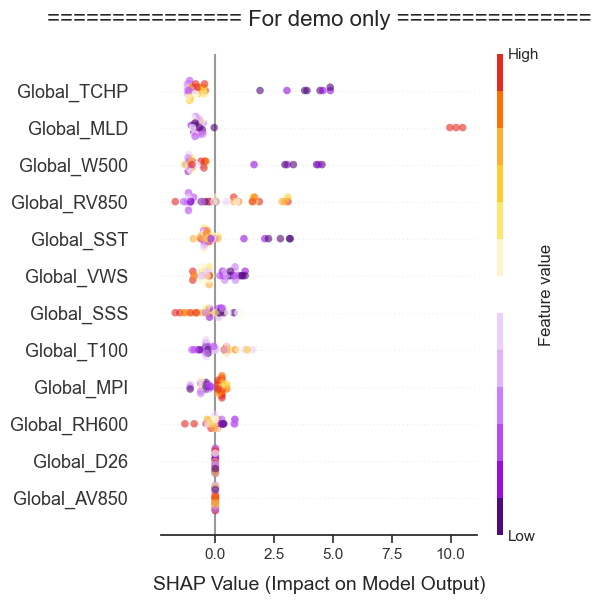

Beeswarm Plot Interpretation:
• Features are ranked by importance (top = most important)
• X-axis: SHAP value = impact on prediction
• Color: Feature value (red = high, blue = low)
• Points: Individual predictions
• Width: Density of SHAP values = feature impact frequency


In [ ]:
# Initialize SHAP Explainer to interpret the trained XGBoost model
# SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction
explainer = shap.Explainer(best_xgb)

# Calculate SHAP values for the entire dataset
# SHAP values represent the impact of each feature on the model output for each sample
shap_values = explainer(X)

# Create beeswarm plot to visualize feature importance and impact
# Beeswarm plots show the distribution of SHAP values for each feature
beeswarm_plot = shap.plots.beeswarm(
    shap_values, 
    max_display=20,           # Display top 20 most important features
    show=False,               # Don't display plot immediately (allows for customization)
    alpha=0.6,                # Transparency of points (0=transparent, 1=opaque)
    s=30,                     # Size of individual points
    color=cmaps.sunshine_diff_12lev,  # Custom color map for better visual distinction
    plot_size=(6, 6),         # Figure size in inches (width, height)
)

# Customize the plot appearance
plt.gcf().set_size_inches(6, 6)  # Adjust final figure size if needed
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14, labelpad=10)  # Clear x-axis label
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure area
plt.title("=============== For demo only ===============", fontsize=16, pad=20)
# plt.savefig('2.png', dpi=300, bbox_inches='tight')
plt.show()

# Print interpretation guide
print("Beeswarm Plot Interpretation:")
print("• Features are ranked by importance (top = most important)")
print("• X-axis: SHAP value = impact on prediction")
print("• Color: Feature value (red = high, blue = low)")
print("• Points: Individual predictions")
print("• Width: Density of SHAP values = feature impact frequency")





PD Numerical Features:  33%|███▎      | 1/3 [08:03<16:06, 483.25s/it]


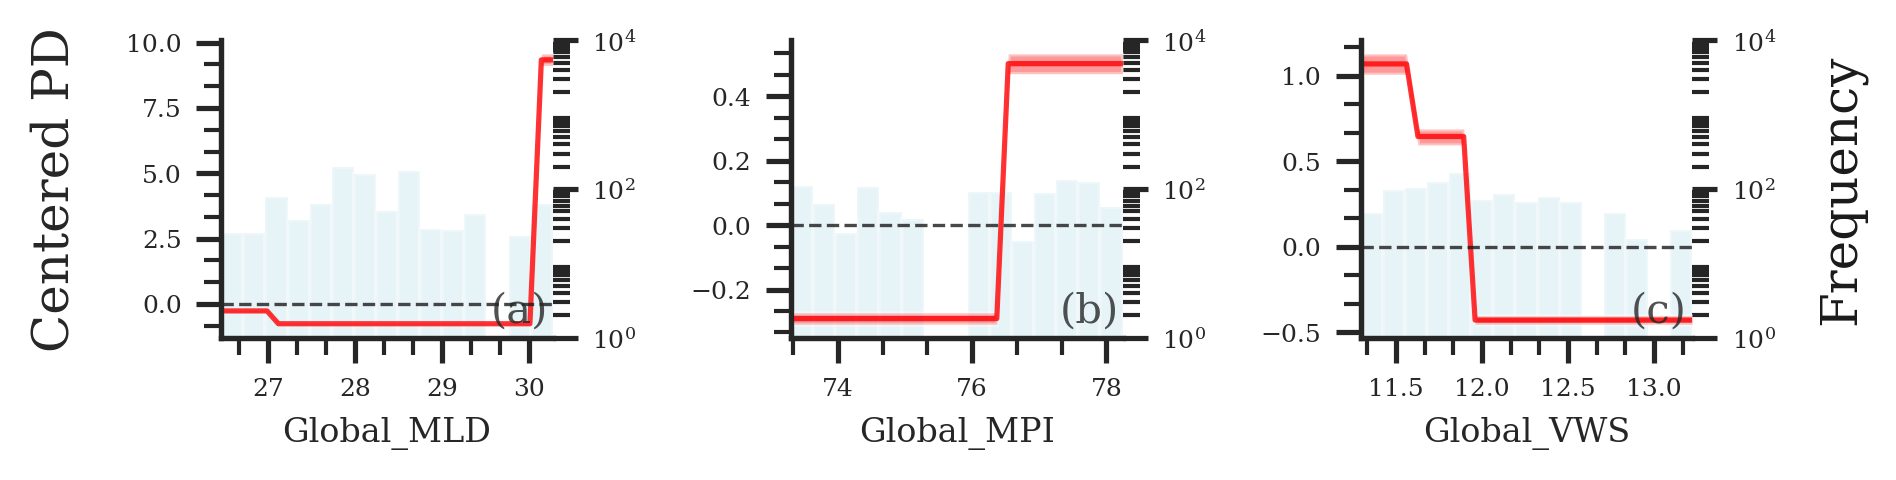

Partial Dependence Plot Interpretation:
• X-axis: Feature values
• Y-axis: Average model prediction (centered)
• Line: Mean partial dependence
• Confidence band: Uncertainty in the relationship
• Steeper slopes indicate stronger feature influence on predictions


In [15]:
# Prepare feature matrix by selecting all columns with 'Global_' prefix
X = IML_data.filter(regex='Global_')
y = IML_data['Global']

# Initialize ExplainToolkit for model interpretation
explainer = ExplainToolkit(('', best_xgb), X=X, y=y)

# Calculate 1D Partial Dependence for selected featuresons
pd_1d = explainer.pd(
    features=['Global_MLD', 'Global_MPI', 'Global_VWS'],  # Specific features to analyze
    n_bootstrap=300,   # Number of bootstrap samples for confidence intervals
    subsample=1000,    # Number of instances to sample for computation efficiency
    n_jobs=1,          # Number of parallel jobs (1 = sequential processing)
    n_bins=30          # Number of bins for discretizing continuous features
)

# Generate Partial Dependence plot with specified dimensions
explainer.plot_pd(
    pd=pd_1d,           # Partial dependence results to visualize
    figsize=(7, 2)      # Figure size: 7 inches wide, 2 inches tall
)

plt.tight_layout()
plt.savefig('3.png', dpi=300, bbox_inches='tight')
plt.show()

# Print interpretation guide
print("Partial Dependence Plot Interpretation:")
print("• X-axis: Feature values")
print("• Y-axis: Average model prediction (centered)")
print("• Line: Mean partial dependence")
print("• Confidence band: Uncertainty in the relationship")
print("• Steeper slopes indicate stronger feature influence on predictions")